In [1]:
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch import nn

In [2]:
if torch.cuda.is_available():
    device = "cuda"
    print("Training on GPU")
else:
    device = "cpu"
    print("Training on CPU")

Training on GPU


In [3]:
dataset = torch.utils.data.ConcatDataset([
    torchvision.datasets.MNIST('./files', train=False, download=True,
                             transform=torchvision.transforms.ToTensor()),
    torchvision.datasets.MNIST('./files', train=True, download=True, transform=torchvision.transforms.ToTensor())
                            ])
                               
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, input_channels, laten_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True, padding=0)
        self.enc_dense = nn.Linear(7 * 7 * 32, laten_dim)
        self.dec_dense = nn.Linear(laten_dim, 7 * 7 * 32)
        self.unpool = nn.MaxUnpool2d(kernel_size=(2, 2), stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(16, input_channels, kernel_size=(3, 3), stride=1, padding=1)
        
    def encoder(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x, indices = self.maxpool(x)
        self.up1_indices = indices 
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x, indices = self.maxpool(x)
        self.up2_indices = indices
        x = x.view((x.shape[0], 7 * 7 * 32))
        x = self.enc_dense(x)
        return x
    
        
    def decoder(self, x):
        x = self.dec_dense(x)
        x = x.view((x.shape[0], 32, 7, 7))
        x = self.unpool(x, self.up2_indices)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.unpool(x, self.up1_indices)
        x = self.conv4(x)
        x = torch.sigmoid(x)
        return x
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

In [5]:
bce_loss = nn.BCELoss()
model = AutoEncoder(1, 5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

losses = []

model.train()
for epoch in range(1, num_epochs + 1):
    running_loss = 0
    iterations = 0
    for x, _ in data_loader:
        x = x.to(device)
        optimizer.zero_grad()
        reconstruction = model(x)
        loss = bce_loss(reconstruction, x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        iterations += 1
        
    cur_loss = running_loss / iterations
    losses.append(cur_loss)
    print(f"Epoch {epoch}/{num_epochs} ==> loss: {cur_loss}")

Epoch 1/10 ==> loss: 0.13973209128410333
Epoch 2/10 ==> loss: 0.07870449947101324
Epoch 3/10 ==> loss: 0.07403211570744976
Epoch 4/10 ==> loss: 0.07214726917649972
Epoch 5/10 ==> loss: 0.0710647515612067
Epoch 6/10 ==> loss: 0.07021252161242626
Epoch 7/10 ==> loss: 0.06961286928797553
Epoch 8/10 ==> loss: 0.06913590165607672
Epoch 9/10 ==> loss: 0.06881086872907617
Epoch 10/10 ==> loss: 0.06847049073883123


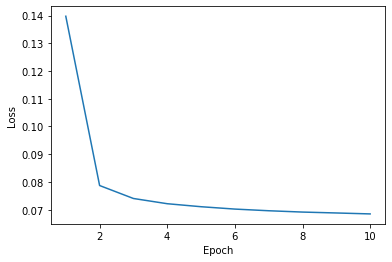

In [6]:
plt.plot(list(range(1, num_epochs + 1)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [7]:
model.eval()
for x, _ in data_loader:
    with torch.no_grad():
        x = x.to(device)
        before = x
        after = model(x)
        break

In [8]:
before = before.cpu().numpy()
after = after.cpu().numpy()

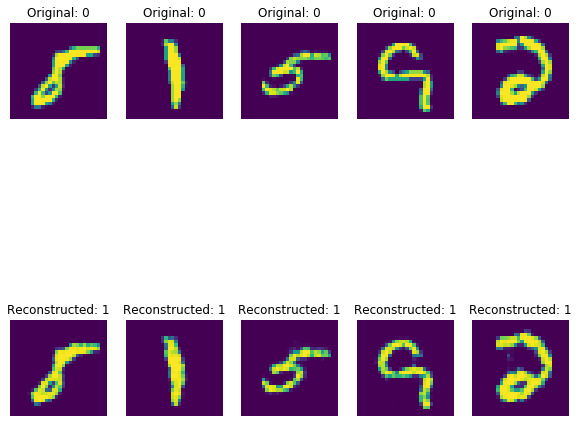

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 10))
for experiment in range(2):
    for col in range(ax.shape[1]):
        ax[experiment][col].axis('off')
        if experiment == 0:
            ax[experiment][col].imshow(before[col].reshape(28, 28))
            ax[experiment][col].set_title(f"Original: {experiment}")
        else:
            ax[experiment][col].imshow(after[col].reshape(28, 28))
            ax[experiment][col].set_title(f"Reconstructed: {experiment}")

In [67]:
class  VariationalAutoEncoder(nn.Module):
    def __init__(self, input_channels, latent_dim, device):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.enc_mean = nn.Linear(7 * 7 * 32, latent_dim)
        self.enc_std = nn.Linear(7 * 7 * 32, latent_dim)
        self.dec_dense = nn.Linear(latent_dim, 7 * 7 * 32)
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, input_channels, kernel_size=(3, 3), stride=2, padding=1, output_padding=1)
        self.latent_dim = latent_dim
        self.device = device
        
    def encoder(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = x.view((x.shape[0], 7 * 7 * 32))
        mean = self.enc_mean(x)
        std = self.enc_std(x)
        return mean, std
    
        
    def decoder(self, x):
        x = self.dec_dense(x)
        x = nn.functional.relu(x)
        x = x.view((x.shape[0], 32, 7, 7))
        x = self.deconv1(x)
        x = nn.functional.relu(x)
        x = self.deconv2(x)
        x = torch.sigmoid(x)
        return x
    
    def reparameterise(self, mean, std):
        eps = torch.normal(torch.zeros_like(mean), torch.ones_like(std))
        return eps * std + mean
        
    def forward(self, x):
        mean, std = self.encoder(x)
        latent = self.reparameterise(mean, std)
        reconstruction = self.decoder(latent)
        return reconstruction, mean, std
    
    def generate(self, num_samples):
        with torch.no_grad():
            eps = torch.normal(torch.zeros((num_samples, self.latent_dim)), torch.ones((num_samples, self.latent_dim))).to(self.device)
            return self.decoder(eps)

def kl_divergence(mean, std):
    variance = std * std
    return torch.sum(mean * mean + variance - 1 - torch.log(variance))
    

In [69]:
bce_loss = nn.BCELoss(reduction='sum')
model = VariationalAutoEncoder(1, 5, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

losses = []
kl_losses = []
reconstruction_losses = []

model.train()
for epoch in range(1, num_epochs + 1):
    running_reconstruction_loss = 0
    running_kl_loss = 0
    iterations = 0
    for x, _ in data_loader:
        x = x.to(device)
        optimizer.zero_grad()
        reconstruction, mean, std = model(x)
        kl_loss = kl_divergence(mean, std)
        reconstruction_loss = bce_loss(reconstruction, x)
        loss = reconstruction_loss + kl_loss
        loss.backward()
        optimizer.step()
        running_reconstruction_loss += reconstruction_loss.item()
        running_kl_loss += kl_loss.item()
        iterations += 1
        
    kl_loss = running_kl_loss / iterations
    reconsruction_loss = running_reconstruction_loss / iterations
    cur_loss = kl_loss + reconstruction_loss
    kl_losses.append(kl_loss)
    reconstruction_losses.append(reconsruction_loss)
    losses.append(cur_loss)
    print(f"Epoch {epoch}/{num_epochs} ==> kl_loss:{kl_loss}, reconstruction_loss: {reconsruction_loss}, loss: {cur_loss}")

Epoch 1/5 ==> kl_loss:1773.9181350066413, reconstruction_loss: 26397.438835409048, loss: 18815.505859375
Epoch 2/5 ==> kl_loss:2087.0646807515427, reconstruction_loss: 17719.82181215722, loss: 17302.671875
Epoch 3/5 ==> kl_loss:2179.2170698036875, reconstruction_loss: 16656.857636111745, loss: 16901.8046875
Epoch 4/5 ==> kl_loss:2226.7389739488117, reconstruction_loss: 16212.441247357747, loss: 16484.38671875
Epoch 5/5 ==> kl_loss:2259.0614618444356, reconstruction_loss: 15949.807151222578, loss: 15366.302734375


In [75]:
model.eval()
samples = model.generate(128)

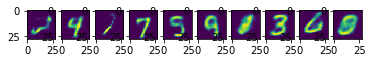

In [76]:
samples = samples.cpu().numpy()
fig, ax = plt.subplots(nrows=1, ncols=10)
for col in range(ax.shape[0]):
    ax[col].imshow(samples[col].reshape((28, 28)))